In [1]:
!pip install einops

In [2]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exist

In [3]:
import os
import torch
from torch import nn
import nibabel as nib
from torch.utils.data import Dataset, DataLoader, random_split
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    RandSpatialCropd,
    RandFlipd,
    RandRotate90d,
    NormalizeIntensityd,
    Compose,
    CenterSpatialCropd
)
from monai.networks.nets import SwinUNETR, ResNetFeatures
from monai.losses import DiceLoss
from torch.optim import Adam
from monai.metrics import DiceMetric
import pandas as pd
import numpy as np
import glob
from tqdm.auto import tqdm
import gc
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import StandardScaler, LabelEncoder
import random
import warnings
import torch.nn.functional as F

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-06-04 15:23:11.992335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749050592.180058      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749050592.238261      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
warnings.filterwarnings("ignore")

In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(31)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
BATCH_SIZE = 4
EPOCHS = 100

In [8]:
train_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    EnsureTyped(keys=["image"]),
    RandSpatialCropd(keys=["image"], roi_size=[64, 64, 64], random_size=False),
    RandFlipd(keys=["image"], spatial_axis=0, prob=0.3),
    RandFlipd(keys=["image"], spatial_axis=1, prob=0.3),
    RandFlipd(keys=["image"], spatial_axis=2, prob=0.3),
    RandRotate90d(keys=["image"], max_k=3, prob=0.3),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

# train_transforms = Compose([
#     LoadImaged(keys=["image"]),
#     EnsureChannelFirstd(keys=["image"]),
#     EnsureTyped(keys=["image"]),
#     CenterSpatialCropd(keys=["image"], roi_size=[64, 64, 64]),
#     NormalizeIntensityd(keys="image", nonzero=False, channel_wise=True)
# ])

val_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    EnsureTyped(keys=["image"]),
    CenterSpatialCropd(keys=["image"], roi_size=[64, 64, 64]),
    NormalizeIntensityd(keys="image", nonzero=False, channel_wise=True)
])

In [9]:
class BrainDataset(Dataset):
    def __init__(self,cognitive_csv_path, dir_path, transform = None):
        super().__init__()
        self.transform = transform
        self.df_cognitive = pd.read_csv(cognitive_csv_path)
        self.dir_path = dir_path
        
        # le = LabelEncoder()
        # self.df_cognitive['PTGENDER'] = le.fit_transform(self.df_cognitive['PTGENDER'])
        
    def __len__(self):
        return len(self.df_cognitive)
    def __getitem__(self, index):
        image_id = self.df_cognitive.iloc[index]['image_id']
        string_image_id = 'I' + str(image_id)
        img_path = os.path.join(self.dir_path, string_image_id, "T1_biascorr_brain.nii")
        
        clinical = self.df_cognitive.iloc[index][['PTGENDER','PTEDUCAT','age','DIAGNOSIS_now']]
        clinical = clinical.astype('float32').values
        clinical = torch.tensor(clinical, dtype=torch.float32)

        time_lapse = self.df_cognitive.iloc[index]['time_lapsed']
        time_lapse = torch.tensor(time_lapse, dtype=torch.float32)
        
        label = self.df_cognitive.iloc[index][['ADAS11_now','ADAS13_now','MMSCORE_now','ADAS11_future','ADAS13_future','MMSCORE_future']]
        label = label.astype('float32').values
        label = torch.tensor(label, dtype=torch.float32)
        
        sample =  {"image": img_path}
        
        if self.transform:
            sample = self.transform(sample)
        mri = sample['image']
        return (mri, clinical, time_lapse), label

In [10]:
traindataset = BrainDataset(cognitive_csv_path = "/kaggle/input/extended-brain-data/train_6_12.csv", 
                            dir_path = "/kaggle/input/fsl-brain-dataset/T1_biascorr_brain_data", 
                            transform = train_transforms)

valdataset = BrainDataset(cognitive_csv_path = "/kaggle/input/extended-brain-data/val_6_12.csv", 
                          dir_path = "/kaggle/input/fsl-brain-dataset/T1_biascorr_brain_data", 
                          transform = val_transforms)

testdataset = BrainDataset(cognitive_csv_path = "/kaggle/input/extended-brain-data/test_6_12.csv", 
                          dir_path = "/kaggle/input/fsl-brain-dataset/T1_biascorr_brain_data", 
                          transform = val_transforms)

In [11]:
train_loader = DataLoader(traindataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(valdataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(testdataset, batch_size = BATCH_SIZE, shuffle = False)

In [12]:
print(len(train_loader), len(val_loader), len(test_loader))

141 16 16


In [13]:
dataframe = traindataset.df_cognitive

In [14]:
dataframe.head()

,PTID,image_id,time_lapsed,DIAGNOSIS_now,ADAS11_now,ADAS13_now,MMSCORE_now,ADAS11_future,ADAS13_future,MMSCORE_future,PTGENDER,PTEDUCAT,age
0,041_S_1425,89727,0.033333,2.0,0.200000,0.270588,0.866667,0.238143,0.325529,0.866667,1,0.55,0.52
1,036_S_4894,323094,0.961111,3.0,0.281000,0.349059,0.733333,0.576143,0.592118,0.600000,1,0.45,0.22
2,033_S_1309,116933,0.050000,2.0,0.152429,0.231412,0.933333,0.123857,0.219647,0.866667,1,0.55,0.42
3,011_S_0023,212946,0.944444,1.0,0.066714,0.113765,0.866667,0.081000,0.113765,0.900000,0,0.45,0.54
4,130_S_4984,364934,0.011111,3.0,0.457143,0.505882,0.500000,0.676143,0.733294,0.400000,1,0.35,0.48


In [15]:
(mri, clinical, time_lapse), label = next(iter(train_loader))
print(mri.shape)
print(clinical)
print(time_lapse.shape)
print(label)

torch.Size([4, 1, 64, 64, 64])
tensor([[0.0000, 0.6500, 0.2600, 3.0000],
        [0.0000, 0.5500, 0.5800, 1.0000],
        [1.0000, 0.3500, 0.2000, 2.0000],
        [0.0000, 0.7000, 0.5800, 3.0000]])
torch.Size([4])
tensor([[0.1761, 0.2509, 0.8000, 0.1761, 0.2745, 0.7000],
        [0.0857, 0.1294, 0.9667, 0.0667, 0.0902, 0.9667],
        [0.2239, 0.2549, 0.8667, 0.2571, 0.2941, 0.8000],
        [0.1143, 0.1765, 0.8667, 0.0761, 0.1333, 0.9333]])


In [35]:
# class ClinicalEncoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),  # giả sử time_lapse là scalar
#             nn.ReLU(),
#             # nn.Dropout(0.1),
#             nn.Linear(hidden_dim, output_dim)
#         )
    
#     def forward(self, x):
#         return self.encoder(x)

class MRIEncoder(nn.Module):
    def __init__(self, pretrained=True, freeze = True):
        super().__init__()
        input_size = (64, 64, 64)  # Kích thước patch đầu vào (ví dụ)
        in_channels = 1            # Số lượng kênh đầu vào
        out_channels = 1           # Số lượng kênh đầu ra (không quan trọng nếu chỉ dùng encoder)
        spatial_dims = 3           # Số chiều không gian
        feature_size = 48          # Kích thước feature map
        depths = [3, 3, 3, 3]       # Số lượng Swin Transformer block trong mỗi stage
        num_heads = [3, 6, 12, 24]  # Số lượng attention head

        self.encoder = SwinUNETR(
            img_size=input_size,
            in_channels=in_channels,
            out_channels=out_channels,
            depths=depths,
            num_heads=num_heads,
            feature_size=feature_size,
            spatial_dims=spatial_dims
        )

        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))

    def forward(self, x):
        features = self.encoder.swinViT(x)[-1]
        pooled = self.pool(features).view(features.size(0), -1)
        return pooled

class ADRegression(nn.Module):
    def __init__(self,
                 clinic_input_dim,
                 clinic_hidden_dim,
                 clinic_output_dim,
                 fusion_hidden_dim,
                 output_dim,
                 pretrained=True,
                 freeze = True):
        super().__init__()

        # self.clinical_encoder = ClinicalEncoder(
        #     clinic_input_dim, clinic_hidden_dim, clinic_output_dim)

        self.mri_encoder = MRIEncoder(pretrained, freeze)

        self.mri_head = nn.Sequential(
            nn.Linear(768, 384),
            nn.LeakyReLU(0.01),
            # nn.Dropout(0.2),
        
            nn.Linear(384, 192),
            nn.LeakyReLU(0.01),
            # nn.Dropout(0.2), 
        )
        
        self.future_demo = nn.Sequential(
            nn.Linear(clinic_input_dim, clinic_hidden_dim),  
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(clinic_hidden_dim, clinic_output_dim)
        )
        
        self.adas11_future = nn.Sequential(
            nn.Linear(192 + 64, fusion_hidden_dim),
            nn.Softplus(),
            nn.Linear(fusion_hidden_dim, 1)  
        )

        self.adas13_future = nn.Sequential(
            nn.Linear(192 + 64, fusion_hidden_dim),
            nn.Softplus(),
            nn.Linear(fusion_hidden_dim, 1) 
        )

        self.mmscore_future = nn.Sequential(
            nn.Linear(192 + 64, fusion_hidden_dim),
            nn.Softplus(),
            nn.Linear(fusion_hidden_dim, 1)  
        )

    def forward(self, mri_input, clinical_input, time_lapse, y_now):

        mri_features = self.mri_encoder(mri_input)
        mri_features = self.mri_head(mri_features)
        # clinical_features = self.clinical_encoder(clinical_input)

        future_features = torch.cat((clinical_input, time_lapse, y_now), dim = 1)
        future_features = self.future_demo(future_features)  # B x 32
        fused_future = torch.cat((mri_features, future_features), dim=1)
        adas11_future = self.adas11_future(fused_future)
        adas13_future = self.adas13_future(fused_future)
        mmscore_future = self.mmscore_future(fused_future)
    
        return adas11_future, adas13_future, mmscore_future

In [17]:
class WeightedSmoothL1Loss(nn.Module):
    def __init__(self, threshold_std=1.0, outlier_weight=2.0, reduction='mean', device=None):
        super().__init__()
        self.threshold_std = threshold_std
        self.outlier_weight = outlier_weight
        self.reduction = reduction
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.smooth_l1 = nn.SmoothL1Loss(reduction='none')

    def forward(self, preds, targets):
        """
        preds, targets: tensors shape (B, N)
        """
        abs_error = (preds - targets).abs()

        # Tính std dev theo batch cho từng output (column)
        std_per_output = targets.std(dim=0, keepdim=True)  # shape (1, N)

        # Xác định outliers
        is_outlier = abs_error > (self.threshold_std * std_per_output)

        # Gán trọng số cho từng phần tử
        weights = torch.ones_like(abs_error, device=preds.device)
        weights[is_outlier] = self.outlier_weight

        # Tính Smooth L1 loss từng phần tử
        loss_raw = self.smooth_l1(preds, targets)

        # Nhân trọng số
        weighted_loss = loss_raw * weights

        # Reduction
        if self.reduction == 'mean':
            return weighted_loss.mean()
        elif self.reduction == 'sum':
            return weighted_loss.sum()
        else:
            return weighted_loss

In [18]:
def train_one_epoch(model, optimizer, loss_fn, train_loader, scaler, device=device):
    model.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    total_loss = 0.0
    
    for batch_idx, ((mri, clinical, time_lapse), y) in pbar:
        mri = mri.to(device)
        clinical = clinical.to(device)
        time_lapse = time_lapse.to(device)
        y = y.to(device)

        adas11_future = y[:, 3].unsqueeze(1)
        adas13_future = y[:, 4].unsqueeze(1)
        mmscore_future = y[:, 5].unsqueeze(1)

        y_now = y[:,0:3]
        # print(y_now.shape)

        with torch.amp.autocast(device_type=device):
            preds = model(mri, clinical, time_lapse.unsqueeze(1), y_now)
            (
                adas11_pred_future,
                adas13_pred_future,
                mmscore_pred_future,
            ) = preds

            loss_adas11_future = loss_fn(adas11_pred_future, adas11_future)
            loss_adas13_future = loss_fn(adas13_pred_future, adas13_future)
            loss_mmscore_future = loss_fn(mmscore_pred_future, mmscore_future)

            loss = (
                loss_adas11_future +
                loss_adas13_future +
                loss_mmscore_future 
            )

            # if torch.isnan(loss):
            #     print(f"Loss is NaN at batch {batch_idx}")

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        avg_loss = total_loss / (batch_idx + 1)
        pbar.set_postfix(loss=avg_loss)


In [19]:
model =  ADRegression(clinic_input_dim = 8, 
                 clinic_hidden_dim = 32, 
                 clinic_output_dim = 64,
                 fusion_hidden_dim = 64,
                 output_dim = 2,
                 pretrained = True,
                 freeze = False).to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    # weight_decay=5e-5
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,      # giảm LR xuống 30% mỗi khi plateau
    patience=4,      # đợi 3 epoch không cải thiện mới giảm
    threshold=1e-4,  # ngưỡng để xem có cải thiện hay không
    min_lr=1e-12,     # LR nhỏ nhất
    verbose=True
)
loss_fn = WeightedSmoothL1Loss(reduction = "mean").to(device)
scaler = torch.amp.GradScaler()

In [20]:
best_loss = float('inf')  # Ban đầu đặt loss tốt nhất là vô cùng

In [21]:
for epoch in tqdm(range(EPOCHS)):
    print("Current LR:", optimizer.param_groups[0]['lr'])
    train_one_epoch(model, optimizer, loss_fn, train_loader, scaler, device=device)
    model.eval()
    total_loss = 0.0
    count = 0
    pbar = tqdm(enumerate(val_loader), leave=True)

    with torch.inference_mode():
        for batch_idx, ((mri, clinical, time_lapse), y) in pbar:
            mri = mri.to(device)
            clinical = clinical.to(device)
            time_lapse = time_lapse.to(device)
            y = y.to(device)

            adas11_future = y[:, 3].unsqueeze(1)
            adas13_future = y[:, 4].unsqueeze(1)
            mmscore_future = y[:, 5].unsqueeze(1)

            y_now = y[:,0:3]
    
            with torch.amp.autocast(device_type=device):
                preds = model(mri, clinical, time_lapse.unsqueeze(1), y_now)
                (
                    adas11_pred_future,
                    adas13_pred_future,
                    mmscore_pred_future,
                ) = preds
    
                loss_adas11_future = loss_fn(adas11_pred_future, adas11_future)
                loss_adas13_future = loss_fn(adas13_pred_future, adas13_future)
                loss_mmscore_future = loss_fn(mmscore_pred_future, mmscore_future)
    
                loss = (
                        loss_adas11_future +
                        loss_adas13_future +
                        loss_mmscore_future)

            total_loss += loss.item()
            count += 1
            pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / count
    print(f"Epoch {epoch}: Avg Test Loss = {avg_loss:.4f}")
    scheduler.step(avg_loss)
    # torch.cuda.empty_cache()
    # gc.collect()
    # Nếu tốt hơn thì lưu model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved Best Model at Epoch {epoch} with loss {best_loss:.4f}")

    if epoch % 5 == 0 and epoch >= 30:
        checkpoint_path = f"checkpoint_epoch_{epoch}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"💾 Saved checkpoint at Epoch {epoch} -> {checkpoint_path}")

  0%|          | 0/100 [00:00<?, ?it/s]

Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 0: Avg Test Loss = 0.0491
✅ Saved Best Model at Epoch 0 with loss 0.0491
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1: Avg Test Loss = 0.0512
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2: Avg Test Loss = 0.0382
✅ Saved Best Model at Epoch 2 with loss 0.0382
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3: Avg Test Loss = 0.0326
✅ Saved Best Model at Epoch 3 with loss 0.0326
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4: Avg Test Loss = 0.0281
✅ Saved Best Model at Epoch 4 with loss 0.0281
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5: Avg Test Loss = 0.0284
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6: Avg Test Loss = 0.0267
✅ Saved Best Model at Epoch 6 with loss 0.0267
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7: Avg Test Loss = 0.0254
✅ Saved Best Model at Epoch 7 with loss 0.0254
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8: Avg Test Loss = 0.0221
✅ Saved Best Model at Epoch 8 with loss 0.0221
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9: Avg Test Loss = 0.0219
✅ Saved Best Model at Epoch 9 with loss 0.0219
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10: Avg Test Loss = 0.0231
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11: Avg Test Loss = 0.0208
✅ Saved Best Model at Epoch 11 with loss 0.0208
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12: Avg Test Loss = 0.0290
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 13: Avg Test Loss = 0.0205
✅ Saved Best Model at Epoch 13 with loss 0.0205
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 14: Avg Test Loss = 0.0207
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 15: Avg Test Loss = 0.0218
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 16: Avg Test Loss = 0.0183
✅ Saved Best Model at Epoch 16 with loss 0.0183
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 17: Avg Test Loss = 0.0208
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 18: Avg Test Loss = 0.0183
✅ Saved Best Model at Epoch 18 with loss 0.0183
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 19: Avg Test Loss = 0.0179
✅ Saved Best Model at Epoch 19 with loss 0.0179
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 20: Avg Test Loss = 0.0162
✅ Saved Best Model at Epoch 20 with loss 0.0162
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 21: Avg Test Loss = 0.0151
✅ Saved Best Model at Epoch 21 with loss 0.0151
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 22: Avg Test Loss = 0.0163
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 23: Avg Test Loss = 0.0136
✅ Saved Best Model at Epoch 23 with loss 0.0136
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 24: Avg Test Loss = 0.0173
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 25: Avg Test Loss = 0.0146
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 26: Avg Test Loss = 0.0151
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 27: Avg Test Loss = 0.0130
✅ Saved Best Model at Epoch 27 with loss 0.0130
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 28: Avg Test Loss = 0.0145
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 29: Avg Test Loss = 0.0157
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 30: Avg Test Loss = 0.0126
✅ Saved Best Model at Epoch 30 with loss 0.0126
💾 Saved checkpoint at Epoch 30 -> checkpoint_epoch_30.pth
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 31: Avg Test Loss = 0.0140
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 32: Avg Test Loss = 0.0137
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 33: Avg Test Loss = 0.0119
✅ Saved Best Model at Epoch 33 with loss 0.0119
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 34: Avg Test Loss = 0.0139
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 35: Avg Test Loss = 0.0136
💾 Saved checkpoint at Epoch 35 -> checkpoint_epoch_35.pth
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 36: Avg Test Loss = 0.0112
✅ Saved Best Model at Epoch 36 with loss 0.0112
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 37: Avg Test Loss = 0.0120
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 38: Avg Test Loss = 0.0130
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 39: Avg Test Loss = 0.0110
✅ Saved Best Model at Epoch 39 with loss 0.0110
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 40: Avg Test Loss = 0.0122
💾 Saved checkpoint at Epoch 40 -> checkpoint_epoch_40.pth
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 41: Avg Test Loss = 0.0124
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 42: Avg Test Loss = 0.0106
✅ Saved Best Model at Epoch 42 with loss 0.0106
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 43: Avg Test Loss = 0.0135
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 44: Avg Test Loss = 0.0125
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 45: Avg Test Loss = 0.0166
💾 Saved checkpoint at Epoch 45 -> checkpoint_epoch_45.pth
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 46: Avg Test Loss = 0.0114
Current LR: 0.0001


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 47: Avg Test Loss = 0.0116
Current LR: 5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 48: Avg Test Loss = 0.0110
Current LR: 5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 49: Avg Test Loss = 0.0111
Current LR: 5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 50: Avg Test Loss = 0.0114
💾 Saved checkpoint at Epoch 50 -> checkpoint_epoch_50.pth
Current LR: 5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 51: Avg Test Loss = 0.0111
Current LR: 5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 52: Avg Test Loss = 0.0109
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 53: Avg Test Loss = 0.0110
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 54: Avg Test Loss = 0.0104
✅ Saved Best Model at Epoch 54 with loss 0.0104
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 55: Avg Test Loss = 0.0102
✅ Saved Best Model at Epoch 55 with loss 0.0102
💾 Saved checkpoint at Epoch 55 -> checkpoint_epoch_55.pth
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 56: Avg Test Loss = 0.0100
✅ Saved Best Model at Epoch 56 with loss 0.0100
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 57: Avg Test Loss = 0.0105
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 58: Avg Test Loss = 0.0099
✅ Saved Best Model at Epoch 58 with loss 0.0099
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 59: Avg Test Loss = 0.0097
✅ Saved Best Model at Epoch 59 with loss 0.0097
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 60: Avg Test Loss = 0.0100
💾 Saved checkpoint at Epoch 60 -> checkpoint_epoch_60.pth
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 61: Avg Test Loss = 0.0106
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 62: Avg Test Loss = 0.0103
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 63: Avg Test Loss = 0.0118
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 64: Avg Test Loss = 0.0096
✅ Saved Best Model at Epoch 64 with loss 0.0096
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 65: Avg Test Loss = 0.0094
✅ Saved Best Model at Epoch 65 with loss 0.0094
💾 Saved checkpoint at Epoch 65 -> checkpoint_epoch_65.pth
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 66: Avg Test Loss = 0.0099
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 67: Avg Test Loss = 0.0100
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 68: Avg Test Loss = 0.0102
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 69: Avg Test Loss = 0.0100
Current LR: 2.5e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 70: Avg Test Loss = 0.0102
💾 Saved checkpoint at Epoch 70 -> checkpoint_epoch_70.pth
Current LR: 1.25e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 71: Avg Test Loss = 0.0098
Current LR: 1.25e-05


  0%|          | 0/141 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 72: Avg Test Loss = 0.0104
Current LR: 1.25e-05


  0%|          | 0/141 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
test_model =  ADRegression(clinic_input_dim = 8, 
                 clinic_hidden_dim = 32, 
                 clinic_output_dim = 64,
                 fusion_hidden_dim = 64,
                 output_dim = 2,
                 pretrained = True,
                 freeze = False).to(device)

In [41]:
# checkpoint = torch.load('/kaggle/input/swinunetr-6_18/pytorch/default/1/best_model.pth', map_location='cpu')
# test_model.load_state_dict(checkpoint)
# cpu

In [42]:
test_model.load_state_dict(torch.load('/kaggle/input/overfitting-swinunetr/pytorch/default/1/best_model (1).pth'))

<All keys matched successfully>

🧍‍♂️ Bệnh nhân 1.1
• Dự đoán tương lai  : [20.210418701171875, 30.242876052856445, 19.09716796875]
• Thực tế tương lai   : [17.670000076293945, 28.670001983642578, 17.0]

🧍‍♂️ Bệnh nhân 1.2
• Dự đoán tương lai  : [24.372007369995117, 39.44834899902344, 18.65534019470215]
• Thực tế tương lai   : [20.329999923706055, 29.329999923706055, 18.0]

🧍‍♂️ Bệnh nhân 1.3
• Dự đoán tương lai  : [7.083896160125732, 12.077702522277832, 30.87283706665039]
• Thực tế tương lai   : [3.3299999237060547, 6.329999923706055, 30.0]

🧍‍♂️ Bệnh nhân 1.4
• Dự đoán tương lai  : [13.465339660644531, 19.834932327270508, 23.932048797607422]
• Thực tế tương lai   : [15.0, 22.000001907348633, 27.0]

🧍‍♂️ Bệnh nhân 2.1
• Dự đoán tương lai  : [5.600552082061768, 7.331729412078857, 27.016761779785156]
• Thực tế tương lai   : [2.669999837875366, 3.6700000762939453, 29.0]

🧍‍♂️ Bệnh nhân 2.2
• Dự đoán tương lai  : [17.67432975769043, 26.044418334960938, 23.929101943969727]
• Thực tế tương lai   : [23.670001983642578, 32.6

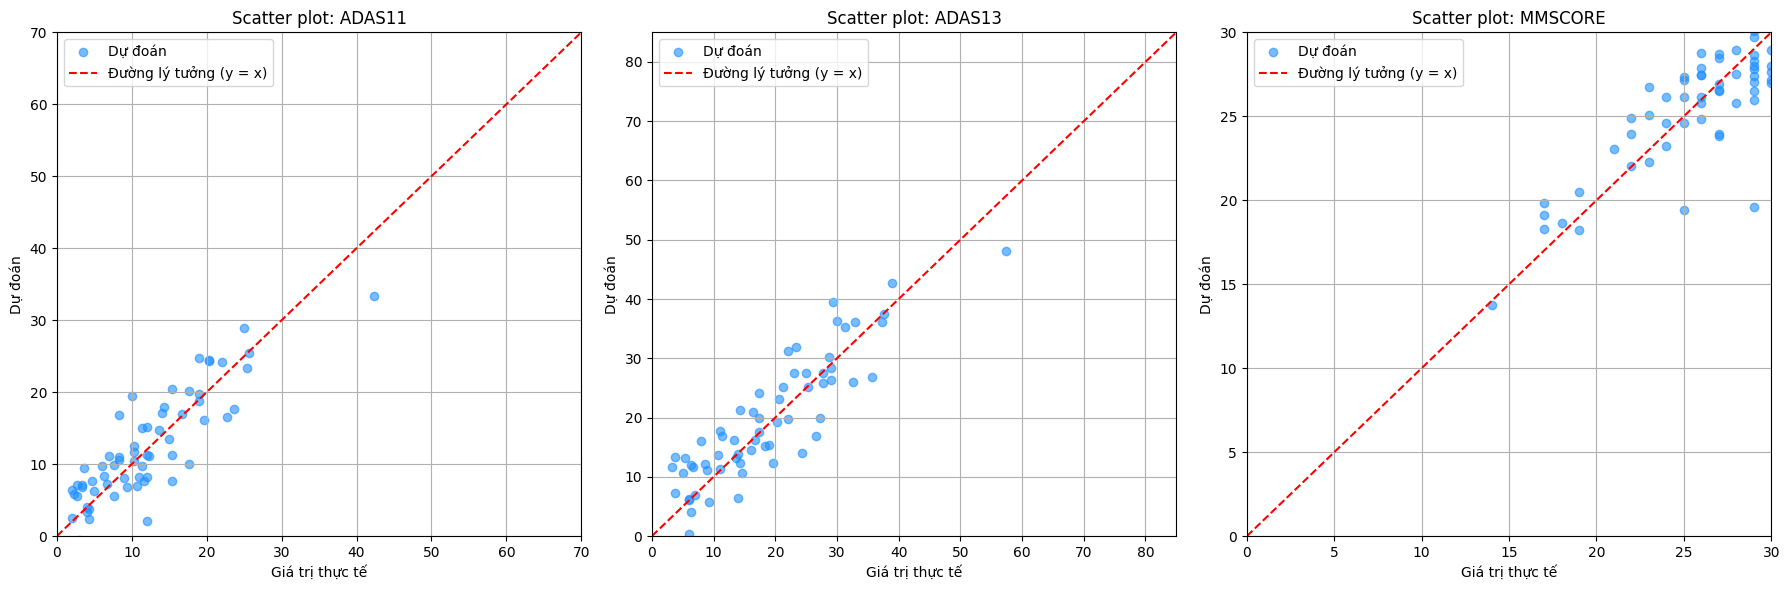

In [43]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

ranges = torch.tensor([70, 85, 30]).to(device)  # Scale cho ADAS11, ADAS13, MMSCORE

test_model.eval()

# Để tính độ lệch trung bình
all_out_now = []
all_out_future = []
all_y_now = []
all_y_future = []

test_iter = iter(test_loader)
for i in range(len(test_loader)):
    ((test_mri, test_clinical, test_time_lapse), test_label) = next(test_iter)
    test_mri, test_clinical, test_label, test_time_lapse = (
        test_mri.to(device),
        test_clinical.to(device),
        test_label.to(device),
        test_time_lapse.to(device),
    )

    y_now = test_label[:,0:3]

    with torch.inference_mode():
        (
            adas11_future,
            adas13_future,
            mmscore_future,
        ) = test_model(test_mri, test_clinical, test_time_lapse.unsqueeze(dim=1), y_now)

        out_future = torch.cat((adas11_future, adas13_future, mmscore_future), dim=1)

        out_future_scaled = out_future * ranges
        y_future_scaled = test_label[:, 3:] * ranges

        all_out_future.append(out_future_scaled)
        all_y_future.append(y_future_scaled)

        for idx in range(test_label.shape[0]):
            print(f"🧍‍♂️ Bệnh nhân {i+1}.{idx+1}")
            print(f"• Dự đoán tương lai  : {out_future_scaled[idx].cpu().numpy().tolist()}")
            print(f"• Thực tế tương lai   : {y_future_scaled[idx].cpu().numpy().tolist()}")
            print()

# Gộp tất cả để tính MAE
out_future_all = torch.cat(all_out_future, dim=0)
y_future_all = torch.cat(all_y_future, dim=0)

y_future_np = y_future_all.cpu().numpy()
out_future_np = out_future_all.cpu().numpy()

mae_future = torch.abs(out_future_all - y_future_all).mean(dim=0)

print("📊 Độ lệch trung bình (MAE):")
print(f"• Tương lai:")
print(f"  - ADAS11  : {mae_future[0]:.2f} điểm")
print(f"  - ADAS13  : {mae_future[1]:.2f} điểm")
print(f"  - MMSCORE : {mae_future[2]:.2f} điểm")

# mse_future = F.mse_loss(out_future_all, y_future_all, reduction='none').mean(dim=0)
rmse_future = []
for i in range(3):
    mse_i = mean_squared_error(y_future_np[:, i], out_future_np[:, i])
    rmse_i = mse_i ** 0.5
    rmse_future.append(rmse_i)
rmse_future = torch.tensor(rmse_future)

print("📈 Căn sai số bình phương trung bình (RMSE):")
print(f"• Tương lai:")
print(f"  - ADAS11  : {rmse_future[0]:.2f} điểm")
print(f"  - ADAS13  : {rmse_future[1]:.2f} điểm")
print(f"  - MMSCORE : {rmse_future[2]:.2f} điểm")

r2_future = [r2_score(y_future_np[:, i], out_future_np[:, i]) for i in range(3)]

print("📊 Hệ số xác định (R² Score):")
print(f"• Tương lai:")
print(f"  - ADAS11  : {r2_future[0]:.4f}")
print(f"  - ADAS13  : {r2_future[1]:.4f}")
print(f"  - MMSCORE : {r2_future[2]:.4f}")

import matplotlib.pyplot as plt

labels = ['ADAS11', 'ADAS13', 'MMSCORE']
ranges = [70, 85, 30]  # Max values của từng chỉ số

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 hàng, 3 cột

for i in range(3):
    max_range = ranges[i]

    axs[i].scatter(y_future_np[:, i], out_future_np[:, i], alpha=0.6, color='dodgerblue', label='Dự đoán')

    # Đường lý tưởng y = x kéo từ 0 đến max_range
    axs[i].plot([0, max_range], [0, max_range], color='red', linestyle='--', label='Đường lý tưởng (y = x)')

    # Giới hạn trục để hiển thị toàn bộ range
    axs[i].set_xlim(0, max_range)
    axs[i].set_ylim(0, max_range)

    axs[i].set_xlabel('Giá trị thực tế')
    axs[i].set_ylabel('Dự đoán')
    axs[i].set_title(f'Scatter plot: {labels[i]}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()